<a href="https://colab.research.google.com/github/JakobSchauser/BachelorProject-IceCube-ML/blob/main/Third_working_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spektral -q

In [ ]:
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.metrics import MeanAbsoluteError as MeanAbsoluteError_acc
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from spektral.data import DisjointLoader, Dataset
from spektral.datasets import QM9
from spektral.layers import ECCConv, GlobalSumPool, GCNConv

from tqdm.notebook import tqdm

PI = np.pi

# Lifehack
true = True
false = False

In [ ]:
################################################################################
# LOAD DATA
################################################################################

class dat(Dataset):
  def __init__(self,n = 1,**kwargs):
    self.n = n
    super().__init__(**kwargs)
  def read(self):
    # path = "/content/drive/MyDrive/Bachelor Project - IceCube ML/generatedDataAnglesEnergy100000 0.npz" # Uncleaned
    path = "/content/drive/MyDrive/Bachelor Project - IceCube ML/generatedDataAnglesEnergyClean200000events 0.npz" # Cleaned
    # path = "/content/drive/MyDrive/Bachelor Project - IceCube ML/data.dat" # From Severin
    dataset = np.load(path,allow_pickle = True)["arr_0"]
    graphs = []
    for g in dataset:
      graphs.append(g)
    return np.array(dataset)

dataset = dat()

print("Dataset is", dataset, "consisting of", dataset[0])



#### Put on GPU when possible
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("Running on GPU")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("Running on CPU")

Dataset is dat(n_graphs=200000) consisting of Graph(n_nodes=13, n_node_features=5, n_edge_features=None, n_labels=3)
Running on GPU


In [ ]:
alls = np.zeros((100000,3))
for k in range(100000):
  alls[k] = dataset[k]["y"]

print(np.max(alls,axis=0))
print(np.min(alls,axis=0))

[1.65156444 0.97610687 0.43305356]
[-0.56945495 -0.99504761 -0.88597444]


In [ ]:
################################################################################
# PARAMETERS
################################################################################
learning_rate = 1e-4  # Learning rate
epochs = 200  # Number of training epochs
test_epochs = 2 # Number of testing epochs
batch_size = 64  # Batch size

network_size = 64 # one-variable network size changer


# Parameters
F = dataset.n_node_features  # Dimension of node features
S = dataset.n_edge_features  # Dimension of edge features
n_out = dataset.n_labels  # Dimension of the target

# Train/test split
idxs = np.random.permutation(len(dataset))
split = int(0.9 * len(dataset))
idx_tr, idx_te = np.split(idxs, [split])
dataset_tr, dataset_te = dataset[idx_tr], dataset[idx_te]

train_loader = DisjointLoader(dataset_tr, batch_size=batch_size, epochs=epochs)
test_loader = DisjointLoader(dataset_te, batch_size=batch_size, epochs=test_epochs, shuffle=True)

In [ ]:
################################################################################
# BUILD MODEL
################################################################################
X_in = Input(shape=(F,), name="X_in")
A_in = Input(shape=(None,), sparse=True, name="A_in")
# E_in = Input(shape=(S,), name="E_in")
I_in = Input(shape=(), name="segment_ids_in", dtype=tf.int32)

x = GCNConv(network_size, activation="relu")([X_in, A_in])
x = GCNConv(network_size*3//4, activation="relu")([x, A_in])
# x = GCNConv(network_size*3//4, activation="relu")([x, A_in])
x = GCNConv(network_size*3//4, activation="relu")([x, A_in])
x = GCNConv(network_size, activation="relu")([x, A_in])

X_out = GlobalSumPool()([x, I_in])
output = Dense(n_out)(X_out)

# Build model
model = Model(inputs=[X_in, A_in, I_in], outputs=output)
opt = Adam(lr=learning_rate)
loss_fn = MeanSquaredError()
# loss_fn = MeanAbsoluteError()
acc_fn = MeanAbsoluteError()
model.compile()
model.summary()


Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X_in (InputLayer)               [(None, 5)]          0                                            
__________________________________________________________________________________________________
A_in (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
gcn_conv_41 (GCNConv)           (None, 64)           320         X_in[0][0]                       
                                                                 A_in[0][0]                       
__________________________________________________________________________________________________
gcn_conv_42 (GCNConv)           (None, 48)           3072        gcn_conv_41[0][0]          

In [ ]:
################################################################################
# FIT MODEL
################################################################################
@tf.function(input_signature=train_loader.tf_signature(), experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions)
        loss += sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    acc = acc_fn(target,predictions)

    return loss, acc

def validate(inputs,target):
    predictions = model(inputs, training=False)
    loss = loss_fn(target, predictions)
    loss += sum(model.losses)
    acc = acc_fn(target,predictions)

    return loss, acc

def scale_inputs(inputs):
    inputs[0][:,:3] = inputs[0][:,:3]/100 # x y z
    inputs[0][:,3] = inputs[0][:,3]/10000 # time
    inputs[0][:,4] = inputs[0][:,4]/1 # charge
    return inputs

def custom_loss(target,predictions):
    predictions = tf.cast(predictions,"float64")

    energy = tf.abs(target[:,0] - predictions[:,0])# tf.square(target[:,0] - predictions[:,0])
    azi, zeni = target[:,1] - predictions[:,1], target[:,2] - predictions[:,2]
    azi  = tf.minimum(tf.abs(azi ), tf.abs(tf.abs(azi )-2))     # 1 should be pi or 2pi
    zeni = tf.minimum(tf.abs(zeni), tf.abs(tf.abs(zeni)-2))  # 1 should be pi or 2pi

    loss = 0
    loss += tf.reduce_mean(energy)
    loss += tf.reduce_mean(azi)
    loss += tf.reduce_mean(zeni)
    return loss


loss_fn = custom_loss

print("Fitting model")

current_batch = 0
model_loss = []
model_acc = []
vali_acc = []
epoch = 0

epoch_steps = train_loader.steps_per_epoch


t = tqdm(train_loader,total  = train_loader.steps_per_epoch*train_loader.epochs,leave = True)
t.set_description(f'Currently on epoch {0} of {epochs} ')

pb = []
tar = []
step = 0

last_vali = 0

for batch in t:
    step += 1
    inputs, target = batch
    inputs = scale_inputs(inputs)

    loss, acc = train_step(inputs,target)

    model_loss.append(loss)
    model_acc.append(acc)
    current_batch += 1
    if current_batch == epoch_steps:
        test_loader = DisjointLoader(dataset_te, batch_size=batch_size, epochs=test_epochs, shuffle=True)
        t.set_description(f'Currently validating results')

        for vali_batch in test_loader:
          vali_inputs, vali_target = vali_batch
          valie_inputs = scale_inputs(vali_inputs)
          vali_loss, va = validate(vali_inputs,vali_target)
          vali_acc.append(vali_loss)
        va = np.mean(vali_acc)
        change = (va-last_vali)/max(0.000001,last_vali)
        last_vali = va
        s = "Train loss: {} - Train accuracy: {} | Validation loss {} - Change {:.3}% | Epoch: {}".format(np.mean(model_loss), np.mean(model_acc), va, change*100, epoch)
        t.write(s)
        if epoch%5 == 0 and epoch != 0:
          print("Two current guesses are\n",np.array(pb[0]),np.array(pb[1]),"for\n",target[0],target[1])
        else:
          pb = model(inputs, training=False)

        model_loss = []
        model_acc = []
        vali_acc = []
        current_batch = 0
        step = 0

        epoch += 1
        t.set_description(f'Currently on epoch {epoch} of {epochs} ')



Fitting model


Train loss: 9.949370232870448 - Train accuracy: 3.8829009532928467 | Validation loss 2.2194749152307582 - Change 2.22e+08% | Epoch: 0
Train loss: 2.7146197449606553 - Train accuracy: 1.3047429323196411 | Validation loss 2.286293002670442 - Change 3.01% | Epoch: 1
Train loss: 2.555598862270437 - Train accuracy: 1.2081291675567627 | Validation loss 4.150399439953168 - Change 81.5% | Epoch: 2
Train loss: 2.356347263354796 - Train accuracy: 1.1212654113769531 | Validation loss 1.7808104302926453 - Change -57.1% | Epoch: 3
Train loss: 2.2263791055156217 - Train accuracy: 1.0469489097595215 | Validation loss 2.0160208750685165 - Change 13.2% | Epoch: 4
Train loss: 2.1554050973163705 - Train accuracy: 1.0174044370651245 | Validation loss 3.0214337615961515 - Change 49.9% | Epoch: 5
Two current guesses are
 [-0.03867785 -0.28356722 -0.14115737] [-0.03900401 -0.69070125 -0.07594608] for
 [ 0.5867794  -0.65371374 -0.28171008] [ 0.87852973 -0.49405871 -0.32781086]
Train loss: 2.060861379746348 - 

KeyboardInterrupt: ignored

In [ ]:
model.save("2e5SavedModel-AnglesEnergy-100epochs")

dataset_targets = ["energy_log10","azimuth","zenith"]
# dataset targets = ["energy_log10", "position_x", "position_y", "position_z", "direction_x", "direction_y", "direction_z"]

INFO:tensorflow:Assets written to: 2e5SavedModel-AnglesEnergy-100epochs/assets


In [ ]:
################################################################################
# EVALUATE MODEL
################################################################################
print("Testing model")
model_loss = 0
model_acc = 0
steps = 0
test_loader = DisjointLoader(dataset_te, batch_size=batch_size, epochs=1)

guesses, diffs, energies = [],[],[]
for batch in test_loader:
  steps += 1
  inputs, target = batch
  inputs[0][:,:3] = inputs[0][:,:3]/100 # x y z
  inputs[0][:,3] = inputs[0][:,3]/10000 # time
  inputs[0][:,4] = inputs[0][:,4]/1 # charge


  predictions = model(inputs, training=False)
  guesses.append(predictions[:,1])
  diffs.append(abs(predictions[:,1]-target[:,1]))
  energies.append(target[:,0])
  model_loss += loss_fn(target, predictions)
  model_acc += acc_fn(target, predictions)

guesses = np.array(guesses).ravel().ravel().ravel().ravel()
energies = np.array(energies).ravel().ravel().ravel().ravel()
diffs = np.array(diffs).ravel().ravel().ravel().ravel()
print("An example for guesses is:")
print(guesses[:5],"for",energies[:5])



print("Done! \nTest loss: {}\nTest Acc: {}".format(model_loss/steps, model_acc/steps))



Testing model
An example for guesses is:
[<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([ 0.9063733 ,  0.17728217, -0.03024403, -0.01259639,  2.4811628 ,
        0.37699458, -0.1460558 ,  0.5022809 ,  1.7350086 ,  0.31723687,
        0.5056485 , -0.5140446 ,  0.11888077, -0.43065378,  1.0691448 ,
       -0.01118759, -0.16767143,  0.31261793,  0.26800376,  0.23806174,
        0.68836504,  0.29599357,  1.3101128 , -0.02684955,  0.22313894,
        0.38272098,  0.23479478,  0.718396  ,  0.9279242 ,  0.18892844,
       -0.0261773 ,  0.29604927, -0.03024403, -0.04030543, -0.40635055,
       -0.61758024, -0.65679795,  0.34905753,  1.061123  ,  0.385035  ,
       -0.6375995 ,  0.9427615 ,  0.42936373,  0.89495784, -0.3213909 ,
       -0.9298025 ,  0.05312846,  0.36532018,  0.00559057,  0.8103903 ,
       -0.6954989 ,  0.18079753,  0.30977997, -0.27039698,  0.06714656,
        0.30883244,  0.4335756 ,  0.3364162 ,  0.5235339 ,  0.4282253 ,
        0.534566  , -0.07458518, -0.5448521 , -

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
energies.shape

(313,)

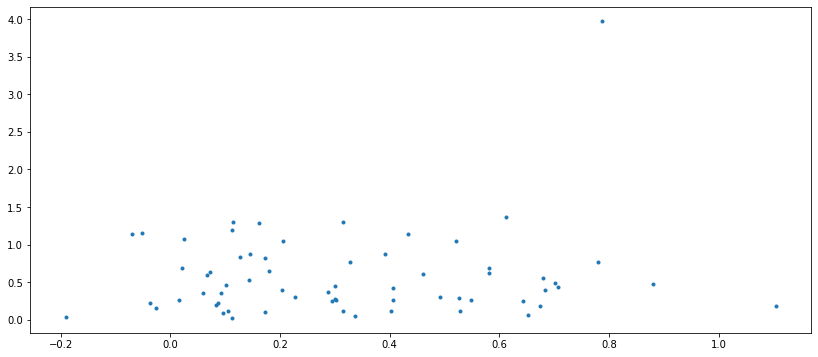

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(energies[1],diffs[1],'.')

In [ ]:
diffs[0][1]